<a href="https://colab.research.google.com/github/chacacaliza/Calculator-BMI/blob/master/CBIR_Brain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Definisikan path kaggle json
# Sesuaikan dengan path anda
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/IR"

In [ ]:
# Ubah lokasi direktori kerja
# Sesuaikan dengan path anda
%cd /content/drive/My Drive/IR

/content/drive/My Drive/IR


In [ ]:
# Cek apakah api sudah terbaca oleh sistem
!ls

kaggle.json


In [ ]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

 60% 9.00M/15.1M [00:01<00:00, 8.55MB/s]
100% 15.1M/15.1M [00:01<00:00, 10.8MB/s]


In [ ]:
# Cek apakah api sudah terbaca oleh sistem
!ls

brain-mri-images-for-brain-tumor-detection.zip	kaggle.json


In [ ]:
# Ekstrak file dataset dan hapus file zip dataset agar tidak memakan banyak tempat.
!unzip \*.zip &> /dev/null && rm *.zip

In [ ]:
# Cek isi direktori kerja untuk memastikan dataset telah berhasil diekstrak.
!ls

brain_tumor_dataset  kaggle.json  no  yes


In [ ]:
from os import mkdir

mkdir('dataset')

In [ ]:
!ls

brain_tumor_dataset  dataset  kaggle.json  no  yes


In [ ]:
import shutil, sys

shutil.move("/content/drive/MyDrive/IR/brain_tumor_dataset/yes", "/content/drive/My Drive/IR/dataset") 
shutil.move("/content/drive/MyDrive/IR/brain_tumor_dataset/no", "/content/drive/My Drive/IR/dataset")

'/content/drive/My Drive/IR/dataset/no'

In [ ]:
import numpy as np
import pandas as pd
import os
from shutil import copyfile

TRAIN_DIR = "/content/drive/My Drive/IR/train/"
TEST_DIR ="/content/drive/My Drive/IR/test/"

os.mkdir(TRAIN_DIR)
os.mkdir(TEST_DIR)

for label in ['no', 'yes']:
    os.mkdir(TRAIN_DIR+label)
    os.mkdir(TEST_DIR+label)

In [ ]:
import random

def train_valid_test_split(source, train_dir, test_dir,train_size, test_size):
    # get files
    files = []
    for filename in os.listdir(source):
        file = source + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
    
    # train valid split
    train_size = int(len(files) * (1-train_size))
    test_size = int(len(files) * (train_size))
  
    # shuffle the dataset
    shuffled_files = random.sample(files, len(files))
    
    train_set = shuffled_files[train_size:]
    test_set = shuffled_files[:train_size]
    
    for filename in train_set:
        filepath = source + filename
        destination = train_dir + filename
        copyfile(filepath, destination)    
    
    for filename in test_set:
        filepath = source + filename
        destination = test_dir + filename
        copyfile(filepath, destination)

SOURCE = "/content/drive/My Drive/IR/dataset/"

for label in ['no', 'yes']:
    print(label)
    train_valid_test_split(SOURCE+label+'/', TRAIN_DIR +label+'/', TEST_DIR +label+'/', train_size=0.8, test_size=0.2)
    print(len(os.listdir(TRAIN_DIR +label+'/')))
    print(len(os.listdir(TEST_DIR +label+'/')))

no
79
19
yes
125
30


In [ ]:
%rm -rf test/
%rm -rf train/

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Lambda ,Dense ,Flatten ,Dropout, BatchNormalization
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 90,
    height_shift_range = 0.2,
    width_shift_range = 0.2,
    zoom_range = 0.2
)

test_generator = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.7
)

In [ ]:
train_images = train_generator.flow_from_directory(
    TRAIN_DIR,
    target_size=(64, 64),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

test_images = test_generator.flow_from_directory(
    TEST_DIR,
    target_size=(64, 64),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42,
    subset = 'validation'
)

Found 204 images belonging to 2 classes.
Found 34 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.5
                                            , min_lr=0.0001
                                            , decay=0.001/32 )

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, GlobalMaxPooling2D, concatenate
from tensorflow.keras.applications import Xception, ResNet50V2, EfficientNetB5, VGG16
from tensorflow.keras.optimizers import Adam

In [ ]:
inputan = (64,64,3)
input_model = Input(shape=inputan)

vgg_model = VGG16(include_top=False, weights="imagenet", input_shape=inputan)(input_model)

def pemodelan(m1):
  model = concatenate([m1])
  model = GlobalMaxPooling2D()(model)
  model = Flatten(name="flatten")(model)
  model = Dense(2048, activation="relu")(model)
  model = Dropout(0.35)(model)
  model = Dense(1024, activation="relu")(model)
  model = Dropout(0.35)(model)
  model = Dense(2, activation="softmax")(model)

  return model

58900480/58889256 [==============================] - 2s 0us/step


In [ ]:
model1= pemodelan(vgg_model)
pemodelan_1 = Model(inputs=input_model, outputs=model1)
pemodelan_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 concatenate (Concatenate)   (None, 2, 2, 512)         0         
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 2048)              1050624   
                                                             

In [ ]:
vgg_model.trainable = False

In [ ]:
import tensorflow as tf
tensorboard=tf.keras.callbacks.TensorBoard(log_dir='./logs/aug')

In [ ]:
%load_ext tensorboard

In [ ]:
!rm -rf ./logs/aug

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
def callback(path):
  checkpoint_callback = ModelCheckpoint(path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)
  reduce_callback = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=0.0001, verbose=1)
  callbacks_list = [checkpoint_callback, reduce_callback]
  return callbacks_list

In [ ]:
best_model_path = 'model1.h5'
cb=callback(best_model_path)

In [ ]:
from tensorflow import keras

In [ ]:
learning_rate=0.0001
pemodelan_1.compile(optimizer=Adam(lr=learning_rate), 
                    loss = keras.losses.CategoricalCrossentropy(),
                    metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = pemodelan_1.fit(train_images,
                    epochs=100,
                    batch_size=128,
                    validation_data=test_images,
                    callbacks=[tensorboard,cb])

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.2077 - accuracy: 0.9167
Epoch 00001: val_accuracy did not improve from 1.00000
7/7 [==============================] - 2s 262ms/step - loss: 0.2077 - accuracy: 0.9167 - val_loss: 0.1055 - val_accuracy: 0.9706 - lr: 1.0000e-04
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.1982 - accuracy: 0.9167
Epoch 00002: val_accuracy did not improve from 1.00000
7/7 [==============================] - 2s 237ms/step - loss: 0.1982 - accuracy: 0.9167 - val_loss: 0.4036 - val_accuracy: 0.8235 - lr: 1.0000e-04
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.2182 - accuracy: 0.9167
Epoch 00003: val_accuracy did not improve from 1.00000
7/7 [==============================] - 2s 236ms/step - loss: 0.2182 - accuracy: 0.9167 - val_loss: 0.1649 - val_accuracy: 0.9412 - lr: 1.0000e-04
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 0.3587 - accuracy: 0.8431
Epoch 00004: val_accuracy

In [ ]:
pemodelan_1.evaluate(test_images)

2/2 [==============================] - 0s 17ms/step - loss: 0.1669 - accuracy: 0.9706


[0.166908398270607, 0.970588207244873]

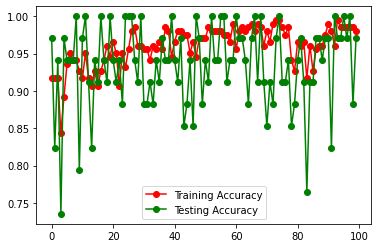

In [ ]:
plt.plot(history.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()

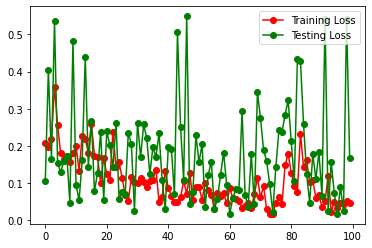

In [ ]:
plt.plot(history.history["loss"] , 'ro-' , label = "Training Loss")
plt.plot(history.history["val_loss"] , 'go-' , label = "Testing Loss")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate(pemodelan_1):
  valid_generator = train_generator.flow_from_directory(
      TRAIN_DIR, 
      target_size=(64,64), 
      batch_size=32, 
      class_mode='categorical',
      shuffle = False)

  batch_size = 32
  num_of_test_samples = len(valid_generator.filenames)

  Y_pred = pemodelan_1.predict_generator(valid_generator, num_of_test_samples // batch_size+1)
  y_pred = np.argmax(Y_pred, axis=1)

  print('\nConfusion Matrix\n')
  cm = confusion_matrix(valid_generator.classes, y_pred)
  plt.figure(figsize=(8, 8))
  sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
  plt.xticks(ticks=[0.5, 1.5], labels=['no', 'yes'])
  plt.yticks(ticks=[0.5, 1.5], labels=['no', 'yes'])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()

  print('\n\nClassification Report\n')
  target_names = ['no', 'yes']
  print(classification_report(valid_generator.classes, y_pred, target_names=target_names))

Found 204 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  from ipykernel import kernelapp as app



Confusion Matrix



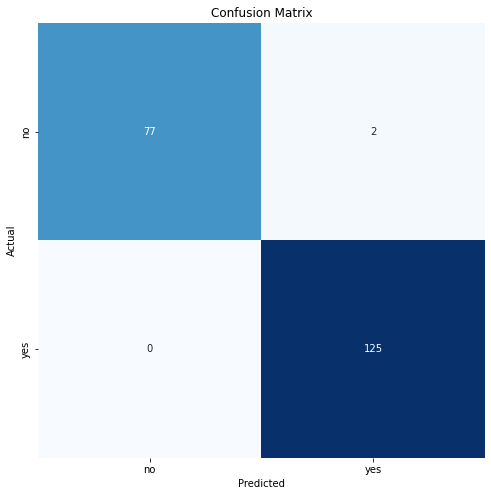



Classification Report

              precision    recall  f1-score   support

          no       1.00      0.97      0.99        79
         yes       0.98      1.00      0.99       125

    accuracy                           0.99       204
   macro avg       0.99      0.99      0.99       204
weighted avg       0.99      0.99      0.99       204



In [ ]:
evaluate(pemodelan_1)

In [ ]:
from os import mkdir

mkdir('data')

In [ ]:
train_dir = "/content/drive/My Drive/IR/data/train/"
test_dir ="/content/drive/My Drive/IR/data/test/"

os.mkdir(train_dir)
os.mkdir(test_dir)

In [ ]:
import glob
import shutil
import os

src_dir = "/content/drive/MyDrive/IR/train/yes"
dst_dir = "/content/drive/My Drive/IR/data/train"
for jpgfile in glob.iglob(os.path.join(src_dir, "*.jpg")):
    shutil.copy(jpgfile, dst_dir)

In [ ]:
src_dir = "/content/drive/MyDrive/IR/train/no"
dst_dir = "/content/drive/My Drive/IR/data/train"
for jpgfile in glob.iglob(os.path.join(src_dir, "*.jpg")):
    shutil.copy(jpgfile, dst_dir)

In [ ]:
src_dir = "/content/drive/MyDrive/IR/test/yes"
dst_dir = "/content/drive/My Drive/IR/data/test"
for jpgfile in glob.iglob(os.path.join(src_dir, "*.jpg")):
    shutil.copy(jpgfile, dst_dir)

In [ ]:
src_dir = "/content/drive/MyDrive/IR/test/no"
dst_dir = "/content/drive/My Drive/IR/data/test"
for jpgfile in glob.iglob(os.path.join(src_dir, "*.jpg")):
    shutil.copy(jpgfile, dst_dir)

In [ ]:
dataset_dir = "/content/drive/My Drive/IR/data/dataset/"

os.mkdir(dataset_dir)

In [ ]:
src_dir = "/content/drive/My Drive/IR/data/test"
dst_dir = "/content/drive/My Drive/IR/data/dataset"
for jpgfile in glob.iglob(os.path.join(src_dir, "*.jpg")):
    shutil.copy(jpgfile, dst_dir)

In [ ]:
src_dir = "/content/drive/My Drive/IR/data/train"
dst_dir = "/content/drive/My Drive/IR/data/dataset"
for jpgfile in glob.iglob(os.path.join(src_dir, "*.jpg")):
    shutil.copy(jpgfile, dst_dir)

In [ ]:
import os

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import  Model

from PIL import Image
import pickle
import numpy as np

def image_preprocess(img):
    img = img.resize((64,64))
    img = img.convert("RGB")
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def extract_vector(model, image_path):
    print("Path : ", image_path)
    img = Image.open(image_path)
    img_tensor = image_preprocess(img)

    vector = model.predict(img_tensor)[0]
    vector = vector / np.linalg.norm(vector)
    return vector

data_folder = "/content/drive/My Drive/IR/data/dataset"

model = pemodelan_1

vectors = []
paths = []

for image_path in os.listdir(data_folder):
    image_path_full = os.path.join(data_folder, image_path)
    image_vector = extract_vector(model,image_path_full)
    vectors.append(image_vector)
    paths.append(image_path_full)

vector_file = "vectors.pkl"
path_file = "paths.pkl"

pickle.dump(vectors, open(vector_file, "wb"))
pickle.dump(paths, open(path_file, "wb"))

Path :  /content/drive/My Drive/IR/data/dataset/Y74.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y154.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y54.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y106.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y107.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y250.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y3.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y69.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y31.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y102.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y95.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y8.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y28.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y39.jpg
Path :  /content/drive/My Drive/IR/data/dataset/10 no.jpg
Path :  /content/drive/My Drive/IR/data/dataset/29 no.jpg
Path :  /content/drive/My Drive/IR/data/dataset/No13.jpg
Path :  /content/drive/My Drive/IR/data/

Dataset :  /content/drive/My Drive/IR/data/test/no 10.jpg


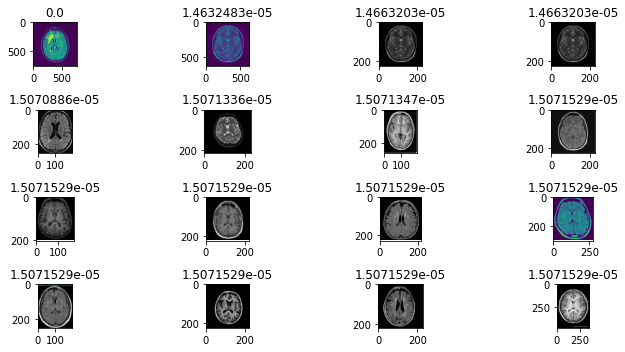

In [ ]:
import math
import os

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import  Model

from PIL import Image
import pickle
import numpy as np

def image_preprocess(img):
    img = img.resize((64,64))
    img = img.convert("RGB")
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def extract_vector(model, image_path):
    print("Dataset : ", image_path)
    img = Image.open(image_path)
    img_tensor = image_preprocess(img)

    vector = model.predict(img_tensor)[0]
    vector = vector / np.linalg.norm(vector)
    return vector

search_image = "/content/drive/My Drive/IR/data/test/no 10.jpg"

model = pemodelan_1

search_vector = extract_vector(model, search_image)

vectors = pickle.load(open("vectors.pkl","rb"))
paths = pickle.load(open("paths.pkl","rb"))

distance = np.linalg.norm(vectors - search_vector, axis=1)

K = 16
ids = np.argsort(distance)[:K]

nearest_image = [(paths[id], distance[id]) for id in ids]

import matplotlib.pyplot as plt

axes = []
grid_size = int(math.sqrt(K))
fig = plt.figure(figsize=(10,5))


for id in range(K):
    draw_image = nearest_image[id]
    axes.append(fig.add_subplot(grid_size, grid_size, id+1))

    axes[-1].set_title(draw_image[1])
    plt.imshow(Image.open(draw_image[0]))

fig.tight_layout()
plt.show()

Model 2

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, GlobalAveragePooling2D, concatenate, BatchNormalization
from tensorflow.keras.applications import Xception, ResNet50V2, EfficientNetB5, VGG16
from tensorflow.keras.optimizers import Adam

In [ ]:
inputan = (64,64,3)
input_model = Input(shape=inputan)

rn50v2 = ResNet50V2(include_top=False, weights="imagenet", input_shape=inputan)(input_model)

def pemodelan2(m1):
  model2 = concatenate([m1])
  model2 = GlobalAveragePooling2D()(model2)
  model2 = Flatten(name="flatten")(model2)
  model2 = Dense(2048, activation="relu")(model2)
  model2 = Dropout(0.25)(model2)
  model2 = BatchNormalization()(model2)
  model2 = Dense(1024, activation="relu")(model2)
  model2 = Dropout(0.25)(model2)
  model2 = BatchNormalization()(model2)
  model2 = Dense(2, activation="softmax")(model2)

  return model2

In [ ]:
model_2= pemodelan2(rn50v2)
pemodelan_2 = Model(inputs=input_model, outputs=model_2)
pemodelan_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 concatenate_2 (Concatenate)  (None, 2, 2, 2048)       0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 2048)              4196352   
                                                           

In [ ]:
rn50v2.trainable = False

In [ ]:
import tensorflow as tf
tensorboard=tf.keras.callbacks.TensorBoard(log_dir='./logs/aug')

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
!rm -rf ./logs/aug

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
def callback(path):
  checkpoint_callback = ModelCheckpoint(path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)
  reduce_callback = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=0.0001, verbose=1)
  callbacks_list = [checkpoint_callback, reduce_callback]
  return callbacks_list

In [ ]:
best_model_path = 'model2.h5'
cb=callback(best_model_path)

In [ ]:
learning_rate=0.0001
pemodelan_2.compile(optimizer=Adam(lr=learning_rate), 
                    loss = keras.losses.CategoricalCrossentropy(),
                    metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history2 = pemodelan_2.fit(train_images,
                    epochs=100,
                    batch_size=128,
                    validation_data=test_images,
                    callbacks=[tensorboard,cb])

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.1380 - accuracy: 0.9461
Epoch 00001: val_accuracy did not improve from 0.97059
7/7 [==============================] - 10s 458ms/step - loss: 0.1380 - accuracy: 0.9461 - val_loss: 0.3179 - val_accuracy: 0.8824 - lr: 1.0000e-04
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.1186 - accuracy: 0.9657
Epoch 00002: val_accuracy did not improve from 0.97059
7/7 [==============================] - 2s 246ms/step - loss: 0.1186 - accuracy: 0.9657 - val_loss: 0.3074 - val_accuracy: 0.9118 - lr: 1.0000e-04
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.0882 - accuracy: 0.9657
Epoch 00003: val_accuracy did not improve from 0.97059
7/7 [==============================] - 2s 242ms/step - loss: 0.0882 - accuracy: 0.9657 - val_loss: 0.3982 - val_accuracy: 0.9118 - lr: 1.0000e-04
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 0.1093 - accuracy: 0.9510
Epoch 00004: val_accurac

In [ ]:
pemodelan_2.evaluate(test_images)

2/2 [==============================] - 0s 32ms/step - loss: 0.5989 - accuracy: 0.8235


[0.5989311933517456, 0.8235294222831726]

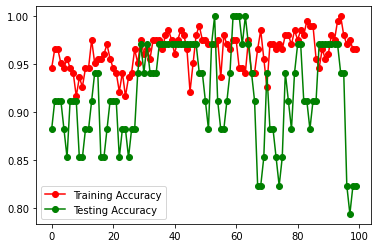

In [ ]:
plt.plot(history2.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history2.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()

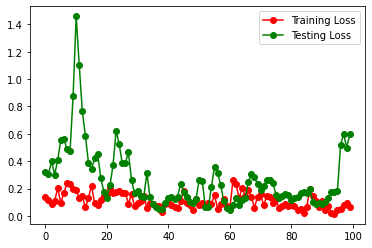

In [ ]:
plt.plot(history2.history["loss"] , 'ro-' , label = "Training Loss")
plt.plot(history2.history["val_loss"] , 'go-' , label = "Testing Loss")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate(pemodelan_2):
  valid_generator = train_generator.flow_from_directory(
      TRAIN_DIR, 
      target_size=(64,64), 
      batch_size=32, 
      class_mode='categorical',
      shuffle = False)

  batch_size = 32
  num_of_test_samples = len(valid_generator.filenames)

  Y_pred = pemodelan_2.predict_generator(valid_generator, num_of_test_samples // batch_size+1)
  y_pred = np.argmax(Y_pred, axis=1)

  print('\nConfusion Matrix\n')
  cm = confusion_matrix(valid_generator.classes, y_pred)
  plt.figure(figsize=(8, 8))
  sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
  plt.xticks(ticks=[0.5, 1.5], labels=['no', 'yes'])
  plt.yticks(ticks=[0.5, 1.5], labels=['no', 'yes'])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()

  print('\n\nClassification Report\n')
  target_names = ['no', 'yes']
  print(classification_report(valid_generator.classes, y_pred, target_names=target_names))

Found 204 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  from ipykernel import kernelapp as app



Confusion Matrix



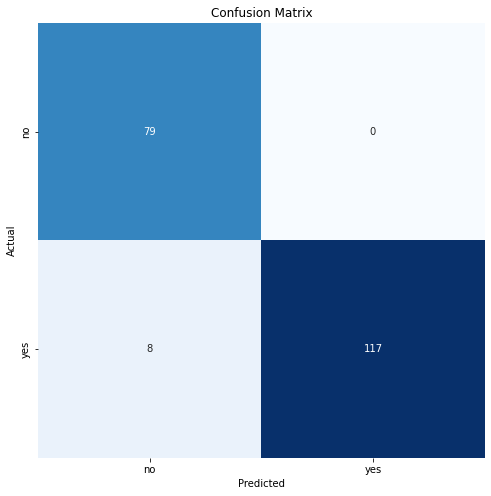



Classification Report

              precision    recall  f1-score   support

          no       0.91      1.00      0.95        79
         yes       1.00      0.94      0.97       125

    accuracy                           0.96       204
   macro avg       0.95      0.97      0.96       204
weighted avg       0.96      0.96      0.96       204



In [ ]:
evaluate(pemodelan_2)

In [ ]:
import os

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import  Model

from PIL import Image
import pickle
import numpy as np

def image_preprocess(img):
    img = img.resize((64,64))
    img = img.convert("RGB")
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def extract_vector(model, image_path):
    print("Path : ", image_path)
    img = Image.open(image_path)
    img_tensor = image_preprocess(img)

    vector = model.predict(img_tensor)[0]
    vector = vector / np.linalg.norm(vector)
    return vector

data_folder = "/content/drive/My Drive/IR/data/dataset"

model = pemodelan_2

vectors = []
paths = []

for image_path in os.listdir(data_folder):
    image_path_full = os.path.join(data_folder, image_path)
    image_vector = extract_vector(model,image_path_full)
    vectors.append(image_vector)
    paths.append(image_path_full)

vector_file = "vectors.pkl"
path_file = "paths.pkl"

pickle.dump(vectors, open(vector_file, "wb"))
pickle.dump(paths, open(path_file, "wb"))

Path :  /content/drive/My Drive/IR/data/dataset/Y74.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y154.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y54.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y106.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y107.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y250.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y3.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y69.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y31.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y102.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y95.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y8.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y28.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y39.jpg
Path :  /content/drive/My Drive/IR/data/dataset/10 no.jpg
Path :  /content/drive/My Drive/IR/data/dataset/29 no.jpg
Path :  /content/drive/My Drive/IR/data/dataset/No13.jpg
Path :  /content/drive/My Drive/IR/data/

Dataset :  /content/drive/My Drive/IR/data/test/no 10.jpg


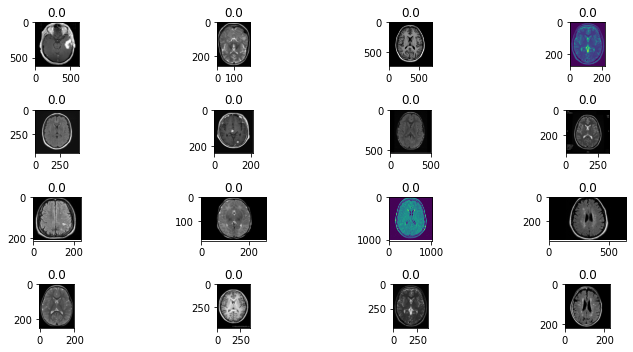

In [ ]:
import math
import os

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import  Model

from PIL import Image
import pickle
import numpy as np

def image_preprocess(img):
    img = img.resize((64,64))
    img = img.convert("RGB")
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def extract_vector(model, image_path):
    print("Dataset : ", image_path)
    img = Image.open(image_path)
    img_tensor = image_preprocess(img)

    vector = model.predict(img_tensor)[0]
    vector = vector / np.linalg.norm(vector)
    return vector

search_image = "/content/drive/My Drive/IR/data/test/no 10.jpg"

model = pemodelan_2

search_vector = extract_vector(model, search_image)

vectors = pickle.load(open("vectors.pkl","rb"))
paths = pickle.load(open("paths.pkl","rb"))

distance = np.linalg.norm(vectors - search_vector, axis=1)

K = 16
ids = np.argsort(distance)[:K]

nearest_image = [(paths[id], distance[id]) for id in ids]

import matplotlib.pyplot as plt

axes = []
grid_size = int(math.sqrt(K))
fig = plt.figure(figsize=(10,5))


for id in range(K):
    draw_image = nearest_image[id]
    axes.append(fig.add_subplot(grid_size, grid_size, id+1))

    axes[-1].set_title(draw_image[1])
    plt.imshow(Image.open(draw_image[0]))

fig.tight_layout()
plt.show()

Model 3

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, GlobalAveragePooling2D, concatenate, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

In [ ]:
inputan = (64,64,3)
input_model = Input(shape=inputan)

mbn2= MobileNetV2(include_top=False, weights="imagenet", input_shape=inputan)(input_model)

def pemodelan3(m1):
  model3 = concatenate([m1])
  model3 = GlobalAveragePooling2D()(model3)
  model3 = Flatten(name="flatten")(model3)
  model3 = Dense(2048, activation="relu")(model3)
  model3 = Dropout(0.25)(model3)
  model3 = BatchNormalization()(model3)
  model3 = Dense(1024, activation="relu")(model3)
  model3 = Dropout(0.25)(model3)
  model3 = BatchNormalization()(model3)
  model3 = Dense(2, activation="softmax")(model3)

  return model3

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
model_3= pemodelan3(mbn2)
pemodelan_3 = Model(inputs=input_model, outputs=model_3)
pemodelan_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 2, 2, 1280)       2257984   
 ional)                                                          
                                                                 
 concatenate_3 (Concatenate)  (None, 2, 2, 1280)       0         
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense_6 (Dense)             (None, 2048)              2623

In [ ]:
mbn2.trainable = False

In [ ]:
import tensorflow as tf
tensorboard=tf.keras.callbacks.TensorBoard(log_dir='./logs/aug')

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
!rm -rf ./logs/aug

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
def callback(path):
  checkpoint_callback = ModelCheckpoint(path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)
  reduce_callback = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=0.0001, verbose=1)
  callbacks_list = [checkpoint_callback, reduce_callback]
  return callbacks_list

In [ ]:
best_model_path = 'model3.h5'
cb=callback(best_model_path)

In [ ]:
learning_rate=0.0001
pemodelan_3.compile(optimizer=Adam(lr=learning_rate), 
                    loss = keras.losses.CategoricalCrossentropy(),
                    metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history3 = pemodelan_3.fit(train_images,
                    epochs=100,
                    batch_size=128,
                    validation_data=test_images,
                    callbacks=[tensorboard,cb])

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.9597 - accuracy: 0.6029
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to model3.h5
7/7 [==============================] - 11s 707ms/step - loss: 0.9597 - accuracy: 0.6029 - val_loss: 0.6686 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.7937 - accuracy: 0.6127
Epoch 00002: val_accuracy did not improve from 0.50000
7/7 [==============================] - 2s 227ms/step - loss: 0.7937 - accuracy: 0.6127 - val_loss: 0.8045 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.7348 - accuracy: 0.6373
Epoch 00003: val_accuracy improved from 0.50000 to 0.52941, saving model to model3.h5
7/7 [==============================] - 3s 424ms/step - loss: 0.7348 - accuracy: 0.6373 - val_loss: 0.7830 - val_accuracy: 0.5294 - lr: 1.0000e-04
Epoch 4/100
7/7 [==============================] - ETA: 0s

In [ ]:
pemodelan_3.evaluate(test_images)

2/2 [==============================] - 0s 20ms/step - loss: 2.1017 - accuracy: 0.6471


[2.101724147796631, 0.6470588445663452]

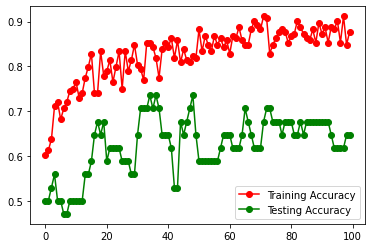

In [ ]:
plt.plot(history3.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history3.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()

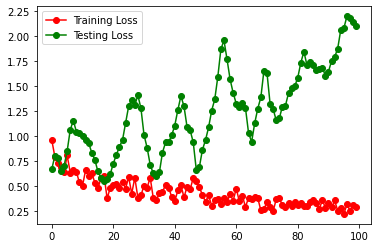

In [ ]:
plt.plot(history3.history["loss"] , 'ro-' , label = "Training Loss")
plt.plot(history3.history["val_loss"] , 'go-' , label = "Testing Loss")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate(pemodelan_3):
  valid_generator = train_generator.flow_from_directory(
      TRAIN_DIR, 
      target_size=(64,64), 
      batch_size=32, 
      class_mode='categorical',
      shuffle = False)

  batch_size = 32
  num_of_test_samples = len(valid_generator.filenames)

  Y_pred = pemodelan_3.predict_generator(valid_generator, num_of_test_samples // batch_size+1)
  y_pred = np.argmax(Y_pred, axis=1)

  print('\nConfusion Matrix\n')
  cm = confusion_matrix(valid_generator.classes, y_pred)
  plt.figure(figsize=(8, 8))
  sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
  plt.xticks(ticks=[0.5, 1.5], labels=['no', 'yes'])
  plt.yticks(ticks=[0.5, 1.5], labels=['no', 'yes'])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()

  print('\n\nClassification Report\n')
  target_names = ['no', 'yes']
  print(classification_report(valid_generator.classes, y_pred, target_names=target_names))

Found 204 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  from ipykernel import kernelapp as app



Confusion Matrix



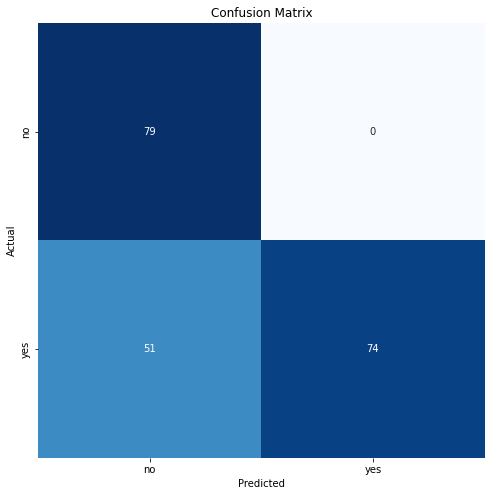



Classification Report

              precision    recall  f1-score   support

          no       0.61      1.00      0.76        79
         yes       1.00      0.59      0.74       125

    accuracy                           0.75       204
   macro avg       0.80      0.80      0.75       204
weighted avg       0.85      0.75      0.75       204



In [ ]:
evaluate(pemodelan_3)

In [ ]:
import os

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import  Model

from PIL import Image
import pickle
import numpy as np

def image_preprocess(img):
    img = img.resize((64,64))
    img = img.convert("RGB")
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def extract_vector(model, image_path):
    print("Path : ", image_path)
    img = Image.open(image_path)
    img_tensor = image_preprocess(img)

    vector = model.predict(img_tensor)[0]
    vector = vector / np.linalg.norm(vector)
    return vector

data_folder = "/content/drive/My Drive/IR/data/dataset"

model = pemodelan_3

vectors = []
paths = []

for image_path in os.listdir(data_folder):
    image_path_full = os.path.join(data_folder, image_path)
    image_vector = extract_vector(model,image_path_full)
    vectors.append(image_vector)
    paths.append(image_path_full)

vector_file = "vectors.pkl"
path_file = "paths.pkl"

pickle.dump(vectors, open(vector_file, "wb"))
pickle.dump(paths, open(path_file, "wb"))

Path :  /content/drive/My Drive/IR/data/dataset/Y74.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y154.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y54.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y106.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y107.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y250.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y3.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y69.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y31.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y102.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y95.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y8.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y28.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y39.jpg
Path :  /content/drive/My Drive/IR/data/dataset/10 no.jpg
Path :  /content/drive/My Drive/IR/data/dataset/29 no.jpg
Path :  /content/drive/My Drive/IR/data/dataset/No13.jpg
Path :  /content/drive/My Drive/IR/data/

Dataset :  /content/drive/My Drive/IR/data/test/no 10.jpg


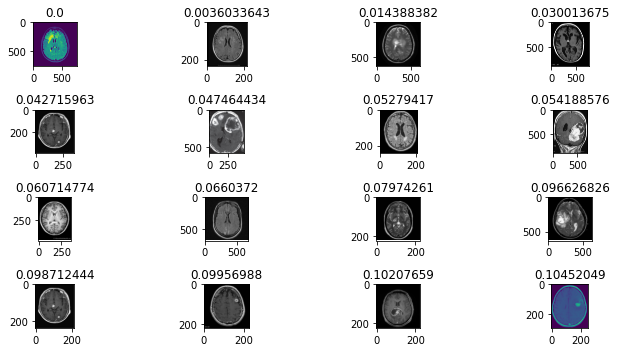

In [ ]:
import math
import os

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import  Model

from PIL import Image
import pickle
import numpy as np

def image_preprocess(img):
    img = img.resize((64,64))
    img = img.convert("RGB")
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def extract_vector(model, image_path):
    print("Dataset : ", image_path)
    img = Image.open(image_path)
    img_tensor = image_preprocess(img)

    vector = model.predict(img_tensor)[0]
    vector = vector / np.linalg.norm(vector)
    return vector

search_image = "/content/drive/My Drive/IR/data/test/no 10.jpg"

model = pemodelan_3

search_vector = extract_vector(model, search_image)

vectors = pickle.load(open("vectors.pkl","rb"))
paths = pickle.load(open("paths.pkl","rb"))

distance = np.linalg.norm(vectors - search_vector, axis=1)

K = 16
ids = np.argsort(distance)[:K]

nearest_image = [(paths[id], distance[id]) for id in ids]

import matplotlib.pyplot as plt

axes = []
grid_size = int(math.sqrt(K))
fig = plt.figure(figsize=(10,5))


for id in range(K):
    draw_image = nearest_image[id]
    axes.append(fig.add_subplot(grid_size, grid_size, id+1))

    axes[-1].set_title(draw_image[1])
    plt.imshow(Image.open(draw_image[0]))

fig.tight_layout()
plt.show()

**MODEL 4**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, GlobalAveragePooling2D, concatenate, BatchNormalization
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.optimizers import Adam

In [ ]:
inputan = (64,64,3)
input_model = Input(shape=inputan)

dns169= DenseNet169(include_top=False, weights="imagenet", input_shape=inputan)(input_model)

def pemodelan4(m1):
  model4 = concatenate([m1])
  model4 = GlobalAveragePooling2D()(model4)
  model4 = Flatten(name="flatten")(model4)
  model4 = Dense(2048, activation="relu")(model4)
  model4 = Dropout(0.25)(model4)
  model4 = BatchNormalization()(model4)
  model4 = Dense(1024, activation="relu")(model4)
  model4 = Dropout(0.25)(model4)
  model4 = BatchNormalization()(model4)
  model4 = Dense(2, activation="softmax")(model4)

  return model4

51888128/51877672 [==============================] - 3s 0us/step


In [ ]:
model_4= pemodelan4(dns169)
pemodelan_4 = Model(inputs=input_model, outputs=model_4)
pemodelan_4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 densenet169 (Functional)    (None, 2, 2, 1664)        12642880  
                                                                 
 concatenate_4 (Concatenate)  (None, 2, 2, 1664)       0         
                                                                 
 global_average_pooling2d_2   (None, 1664)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten (Flatten)           (None, 1664)              0         
                                                                 
 dense_9 (Dense)             (None, 2048)              3409920   
                                                           

In [ ]:
dns169.trainable = False

In [ ]:
import tensorflow as tf
tensorboard=tf.keras.callbacks.TensorBoard(log_dir='./logs/aug')

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
!rm -rf ./logs/aug

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
def callback(path):
  checkpoint_callback = ModelCheckpoint(path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)
  reduce_callback = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=0.0001, verbose=1)
  callbacks_list = [checkpoint_callback, reduce_callback]
  return callbacks_list

In [ ]:
best_model_path = 'model4.h5'
cb=callback(best_model_path)

In [ ]:
learning_rate=0.0001
pemodelan_4.compile(optimizer=Adam(lr=learning_rate), 
                    loss = keras.losses.CategoricalCrossentropy(),
                    metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history4 = pemodelan_4.fit(train_images,
                    epochs=100,
                    batch_size=128,
                    validation_data=test_images,
                    callbacks=[tensorboard,cb])

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.8884 - accuracy: 0.5637
Epoch 00001: val_accuracy improved from -inf to 0.67647, saving model to model4.h5
7/7 [==============================] - 36s 2s/step - loss: 0.8884 - accuracy: 0.5637 - val_loss: 0.5709 - val_accuracy: 0.6765 - lr: 1.0000e-04
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.7529 - accuracy: 0.6667
Epoch 00002: val_accuracy improved from 0.67647 to 0.79412, saving model to model4.h5
7/7 [==============================] - 7s 1s/step - loss: 0.7529 - accuracy: 0.6667 - val_loss: 0.5058 - val_accuracy: 0.7941 - lr: 1.0000e-04
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.6270 - accuracy: 0.6961
Epoch 00003: val_accuracy did not improve from 0.79412
7/7 [==============================] - 2s 277ms/step - loss: 0.6270 - accuracy: 0.6961 - val_loss: 0.4642 - val_accuracy: 0.7941 - lr: 1.0000e-04
Epoch 4/100
7/7 [==============================] - ETA: 0s - los

In [ ]:
pemodelan_4.evaluate(test_images)

2/2 [==============================] - 0s 69ms/step - loss: 0.2994 - accuracy: 0.9706


[0.29935765266418457, 0.970588207244873]

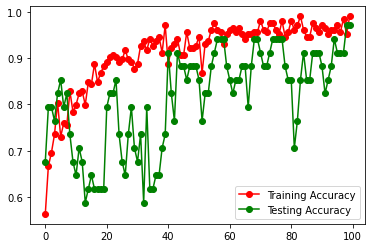

In [ ]:
plt.plot(history4.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history4.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()

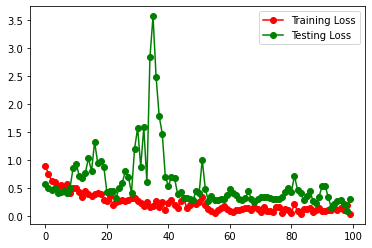

In [ ]:
plt.plot(history4.history["loss"] , 'ro-' , label = "Training Loss")
plt.plot(history4.history["val_loss"] , 'go-' , label = "Testing Loss")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate(pemodelan_4):
  valid_generator = train_generator.flow_from_directory(
      TRAIN_DIR, 
      target_size=(64,64), 
      batch_size=32, 
      class_mode='categorical',
      shuffle = False)

  batch_size = 32
  num_of_test_samples = len(valid_generator.filenames)

  Y_pred = pemodelan_4.predict_generator(valid_generator, num_of_test_samples // batch_size+1)
  y_pred = np.argmax(Y_pred, axis=1)

  print('\nConfusion Matrix\n')
  cm = confusion_matrix(valid_generator.classes, y_pred)
  plt.figure(figsize=(8, 8))
  sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
  plt.xticks(ticks=[0.5, 1.5], labels=['no', 'yes'])
  plt.yticks(ticks=[0.5, 1.5], labels=['no', 'yes'])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()

  print('\n\nClassification Report\n')
  target_names = ['no', 'yes']
  print(classification_report(valid_generator.classes, y_pred, target_names=target_names))

Found 204 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  from ipykernel import kernelapp as app



Confusion Matrix



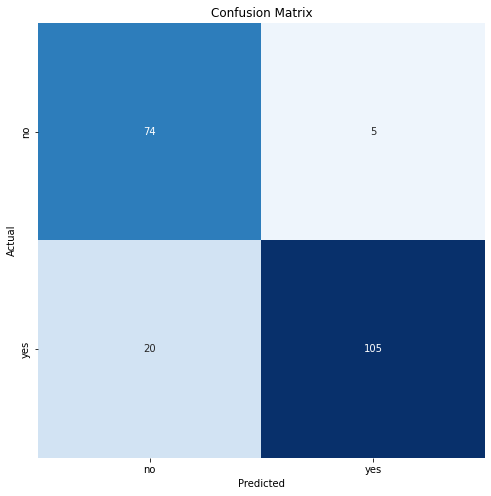



Classification Report

              precision    recall  f1-score   support

          no       0.79      0.94      0.86        79
         yes       0.95      0.84      0.89       125

    accuracy                           0.88       204
   macro avg       0.87      0.89      0.87       204
weighted avg       0.89      0.88      0.88       204



In [ ]:
evaluate(pemodelan_4)

In [ ]:
import os

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import  Model

from PIL import Image
import pickle
import numpy as np

def image_preprocess(img):
    img = img.resize((64,64))
    img = img.convert("RGB")
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def extract_vector(model, image_path):
    print("Path : ", image_path)
    img = Image.open(image_path)
    img_tensor = image_preprocess(img)

    vector = model.predict(img_tensor)[0]
    vector = vector / np.linalg.norm(vector)
    return vector

data_folder = "/content/drive/My Drive/IR/data/dataset"

model = pemodelan_4

vectors = []
paths = []

for image_path in os.listdir(data_folder):
    image_path_full = os.path.join(data_folder, image_path)
    image_vector = extract_vector(model,image_path_full)
    vectors.append(image_vector)
    paths.append(image_path_full)

vector_file = "vectors.pkl"
path_file = "paths.pkl"

pickle.dump(vectors, open(vector_file, "wb"))
pickle.dump(paths, open(path_file, "wb"))

Path :  /content/drive/My Drive/IR/data/dataset/Y74.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y154.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y54.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y106.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y107.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y250.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y3.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y69.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y31.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y102.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y95.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y8.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y28.jpg
Path :  /content/drive/My Drive/IR/data/dataset/Y39.jpg
Path :  /content/drive/My Drive/IR/data/dataset/10 no.jpg
Path :  /content/drive/My Drive/IR/data/dataset/29 no.jpg
Path :  /content/drive/My Drive/IR/data/dataset/No13.jpg
Path :  /content/drive/My Drive/IR/data/

Dataset :  /content/drive/My Drive/IR/data/test/no 10.jpg


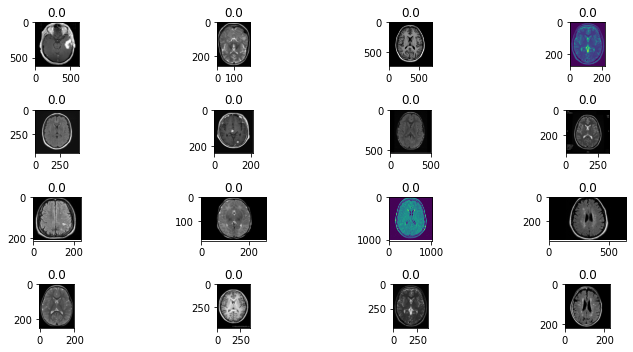

In [ ]:
import math
import os

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import  Model

from PIL import Image
import pickle
import numpy as np

def image_preprocess(img):
    img = img.resize((64,64))
    img = img.convert("RGB")
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def extract_vector(model, image_path):
    print("Dataset : ", image_path)
    img = Image.open(image_path)
    img_tensor = image_preprocess(img)

    vector = model.predict(img_tensor)[0]
    vector = vector / np.linalg.norm(vector)
    return vector

search_image = "/content/drive/My Drive/IR/data/test/no 10.jpg"

model = pemodelan_4

search_vector = extract_vector(model, search_image)

vectors = pickle.load(open("vectors.pkl","rb"))
paths = pickle.load(open("paths.pkl","rb"))

distance = np.linalg.norm(vectors - search_vector, axis=1)

K = 16
ids = np.argsort(distance)[:K]

nearest_image = [(paths[id], distance[id]) for id in ids]

import matplotlib.pyplot as plt

axes = []
grid_size = int(math.sqrt(K))
fig = plt.figure(figsize=(10,5))


for id in range(K):
    draw_image = nearest_image[id]
    axes.append(fig.add_subplot(grid_size, grid_size, id+1))

    axes[-1].set_title(draw_image[1])
    plt.imshow(Image.open(draw_image[0]))

fig.tight_layout()
plt.show()